In [1]:
import os
import numpy as np
import seaborn as sns # for plots
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from scipy import stats as ss # to calcualte confidence intervals, etc
from adjustText import adjust_text # to adjust the text labels in the plots (pip install adjustText)
from scipy.stats import ttest_rel 
from statsmodels.stats.anova import AnovaRM # perform F test

import cortico_cereb_connectivity.globals as gl
import Functional_Fusion.atlas_map as am
import Functional_Fusion.dataset as ds
import selective_recruitment.data as sd
import selective_recruitment.regress as sr
import selective_recruitment.plotting as sp

wkdir = gl.conn_dir + '/selective_recruitment'


/opt/miniconda3/lib/python3.9/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


## Global comparison of MDTB conditions in cortex and cerebellum

In [2]:
Y,X,info=sd.get_voxdata_cereb_cortex(dataset='MDTB',ses_id='all')

In [3]:
# Aggregate into the standard data frame for selective recruitment
n_subj = X.shape[0  ]
vec = np.ones((len(info),))
summary_list = []
labels, info['cond_num_uni'] = np.unique(info.cond_name,return_inverse=True)
for i in range(n_subj):
    info_sub = pd.DataFrame({"sn": i * vec,
            "roi": 1 * vec,
            "X":  np.nanmean(X[i,:,:],axis=1),
            "Y":  np.nanmean(Y[i,:,:],axis=1),
            "cond_name": info["cond_name"],
            "cond_num_uni": info["cond_num_uni"],
            "sess": info["sess"]})
    summary_list.append(info_sub)
T= pd.concat(summary_list,ignore_index=True)


In [4]:
T = sr.roi_regress(T,fit_intercept = True)

/Users/jdiedrichsen/Python/selective_recruitment/plotting.py:114: UserWarning: 
The markers list has fewer values (1) than needed (47) and will cycle, which may produce an uninterpretable plot.
  ax = sns.scatterplot(data=df, x='X', y='Y', style = split, hue = split, s = 100,legend=None,markers=markers,palette=colors)


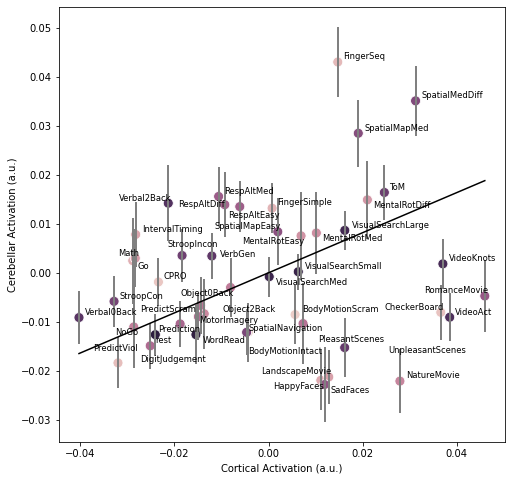

In [9]:
plt.figure(figsize=(8,8))
sp.make_scatterplot(T, split='cond_num_uni',labels = 'cond_name')
plt.savefig('MDTB_all.pdf',dpi=300,bbox_inches='tight')

## Connectivity based comparision

In [4]:
D = sd.get_summary_conn(dataset = "MDTB",
            ses_id = 'all',
            type = "CondHalf",
            cerebellum_roi = None,
            cortex_roi = "Icosahedron1002",
            add_rest = False,
            mname_base = 'MDTB_all_Icosahedron1002_L2regression',
            mname_ext = '_a8',
            crossed = True)
labels, D['cond_num_uni'] = np.unique(D.cond_name,return_inverse=True)
D = sr.roi_regress(D,fit_intercept = True)
D.to_csv(wkdir + '/MDTB_avrg_cMDTB.tsv',sep='\t')


/Users/jdiedrichsen/Python/Functional_Fusion/dataset.py:173: RuntimeWarning: Mean of empty slice
  parcel_data[..., i] = fcn(


In [18]:
D = sd.get_summary_conn(dataset = "MDTB",
            ses_id = 'all',
            type = "CondHalf",
            cerebellum_roi = 'NettekovenSym32',
            cerebellum_roi_selected = ['M','A','D','S'],
            cortex_roi = "Icosahedron1002",
            add_rest = False,
            mname_base = 'MDTB_all_Icosahedron1002_L2regression',
            mname_ext = '_a8',
            crossed = True)
labels, D['cond_num_uni'] = np.unique(D.cond_name,return_inverse=True)
D = sr.roi_regress(D,fit_intercept = True)
D.to_csv(wkdir + '/MDTB_separate_cMDTB.tsv',sep='\t')

/Users/jdiedrichsen/Python/Functional_Fusion/dataset.py:173: RuntimeWarning: Mean of empty slice
  parcel_data[..., i] = fcn(


In [19]:
D = sd.get_summary_conn(dataset = "MDTB",
            ses_id = 'all',
            type = "CondHalf",
            cerebellum_roi = None,
            cortex_roi = "Icosahedron1002",
            add_rest = False,
            mname_base = 'Fusion_all_Icosahedron1002_L2regression',
            mname_ext = '_05',
            crossed = True)
labels, D['cond_num_uni'] = np.unique(D.cond_name,return_inverse=True)
D = sr.roi_regress(D,fit_intercept = True)
D.to_csv(wkdir + '/MDTB_avrg_cFusion5.tsv',sep='\t')

In [20]:
D = sd.get_summary_conn(dataset = "MDTB",
            ses_id = 'all',
            type = "CondHalf",
            cerebellum_roi = 'NettekovenSym32',
            cerebellum_roi_selected = ['M','A','D','S'],
            cortex_roi = "Icosahedron1002",
            add_rest = False,
            mname_base = 'Fusion_all_Icosahedron1002_L2regression',
            mname_ext = '_05',
            crossed = True)
labels, D['cond_num_uni'] = np.unique(D.cond_name,return_inverse=True)
D = sr.roi_regress(D,fit_intercept = True)
D.to_csv(wkdir + '/MDTB_separate_cFusion5.tsv',sep='\t')

/Users/jdiedrichsen/Python/selective_recruitment/plotting.py:114: UserWarning: 
The markers list has fewer values (1) than needed (47) and will cycle, which may produce an uninterpretable plot.
  ax = sns.scatterplot(data=df, x='X', y='Y', style = split, hue = split, s = 100,legend=None,markers=markers,palette=colors)


<AxesSubplot:xlabel='Cortical Activation (a.u.)', ylabel='Cerebellar Activation (a.u.)'>

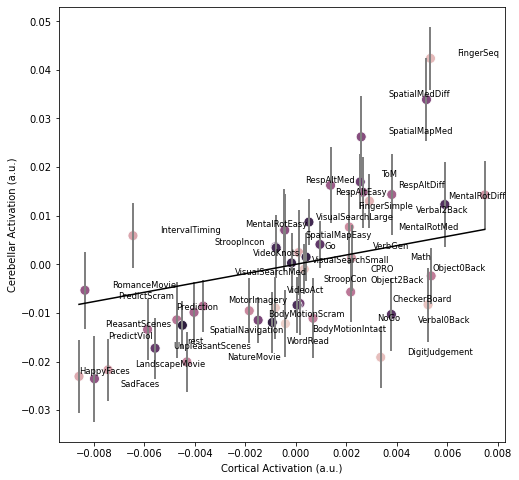

In [20]:
D= pd.read_csv(wkdir + '/MDTB_avrg_cMDTB.tsv',sep='\t')
plt.figure(figsize=(8,8))
sp.make_scatterplot(D, split='cond_num_uni',labels = 'cond_name')


/Users/jdiedrichsen/Python/selective_recruitment/plotting.py:114: UserWarning: 
The markers list has fewer values (1) than needed (47) and will cycle, which may produce an uninterpretable plot.
  ax = sns.scatterplot(data=df, x='X', y='Y', style = split, hue = split, s = 100,legend=None,markers=markers,palette=colors)


<AxesSubplot:xlabel='Cortical Activation (a.u.)', ylabel='Cerebellar Activation (a.u.)'>

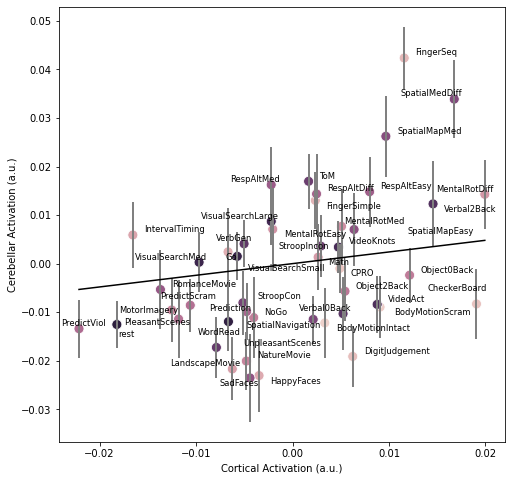

In [21]:
D= pd.read_csv(wkdir + '/MDTB_avrg_cFusion5.tsv',sep='\t')
plt.figure(figsize=(8,8))
sp.make_scatterplot(D, split='cond_num_uni',labels = 'cond_name')

/Users/jdiedrichsen/Python/selective_recruitment/plotting.py:114: UserWarning: 
The markers list has fewer values (1) than needed (47) and will cycle, which may produce an uninterpretable plot.
  ax = sns.scatterplot(data=df, x='X', y='Y', style = split, hue = split, s = 100,legend=None,markers=markers,palette=colors)


<AxesSubplot:xlabel='Cortical Activation (a.u.)', ylabel='Cerebellar Activation (a.u.)'>

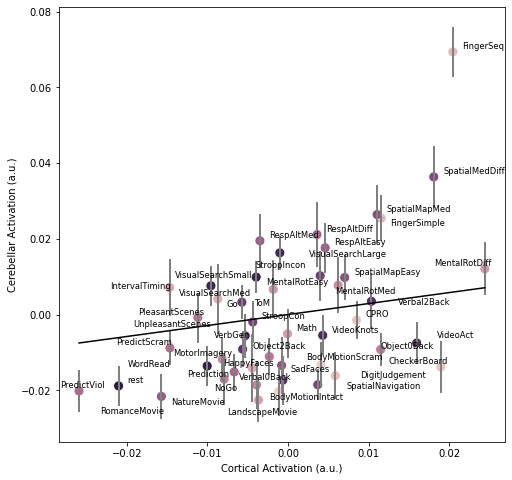

In [22]:
D= pd.read_csv(wkdir + '/MDTB_separate_cFusion5.tsv',sep='\t')
plt.figure(figsize=(8,8))
sp.make_scatterplot(D[D.roi_name=='M'], split='cond_num_uni',labels = 'cond_name')

/Users/jdiedrichsen/Python/selective_recruitment/plotting.py:114: UserWarning: 
The markers list has fewer values (1) than needed (47) and will cycle, which may produce an uninterpretable plot.
  ax = sns.scatterplot(data=df, x='X', y='Y', style = split, hue = split, s = 100,legend=None,markers=markers,palette=colors)


<AxesSubplot:xlabel='Cortical Activation (a.u.)', ylabel='Cerebellar Activation (a.u.)'>

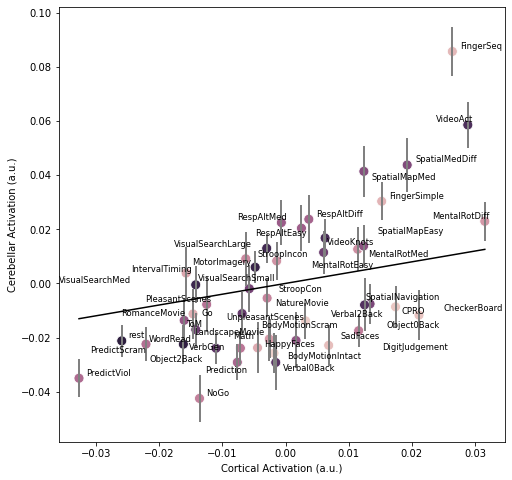

In [23]:
D= pd.read_csv(wkdir + '/MDTB_separate_cFusion5.tsv',sep='\t')
plt.figure(figsize=(8,8))
sp.make_scatterplot(D[D.roi_name=='A'], split='cond_num_uni',labels = 'cond_name')

/Users/jdiedrichsen/Python/selective_recruitment/plotting.py:114: UserWarning: 
The markers list has fewer values (1) than needed (47) and will cycle, which may produce an uninterpretable plot.
  ax = sns.scatterplot(data=df, x='X', y='Y', style = split, hue = split, s = 100,legend=None,markers=markers,palette=colors)


<AxesSubplot:xlabel='Cortical Activation (a.u.)', ylabel='Cerebellar Activation (a.u.)'>

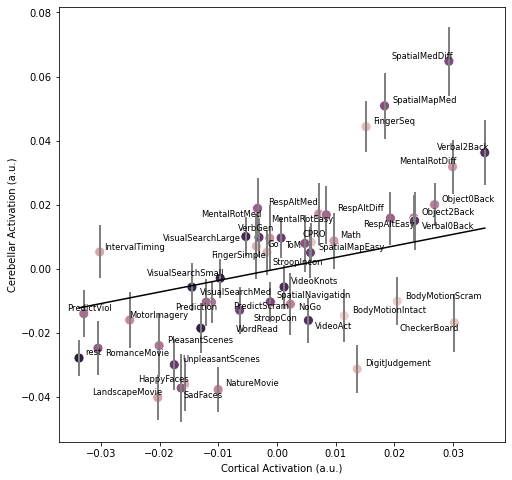

In [24]:
D= pd.read_csv(wkdir + '/MDTB_separate_cFusion5.tsv',sep='\t')
plt.figure(figsize=(8,8))
sp.make_scatterplot(D[D.roi_name=='D'], split='cond_num_uni',labels = 'cond_name')

/Users/jdiedrichsen/Python/selective_recruitment/plotting.py:114: UserWarning: 
The markers list has fewer values (1) than needed (47) and will cycle, which may produce an uninterpretable plot.
  ax = sns.scatterplot(data=df, x='X', y='Y', style = split, hue = split, s = 100,legend=None,markers=markers,palette=colors)


<AxesSubplot:xlabel='Cortical Activation (a.u.)', ylabel='Cerebellar Activation (a.u.)'>

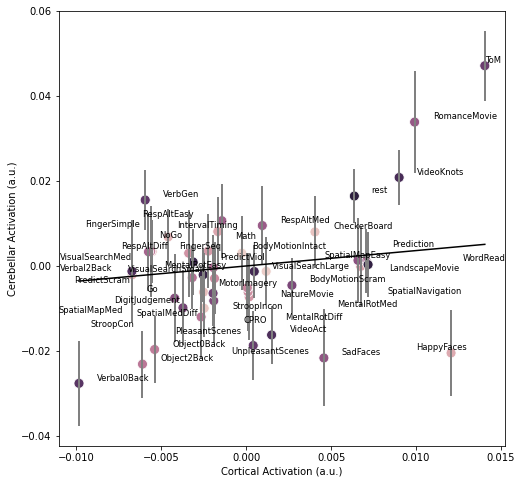

In [25]:
D= pd.read_csv(wkdir + '/MDTB_separate_cFusion5.tsv',sep='\t')
plt.figure(figsize=(8,8))
sp.make_scatterplot(D[D.roi_name=='S'], split='cond_num_uni',labels = 'cond_name')